In [1]:
#!pip install -Uqq fastbook

In [2]:
from fastbook import *
import numpy as np
import os

In [21]:
urls = search_images_ddg('bird photos', max_images=10)
len(urls), urls[0]

(10,
 'http://www.birdsandblooms.com/wp-content/uploads/2015/03/Bluebird-pair.jpg')

In [22]:
dest = Path('bird.jpg')
if not dest.exists(): download_url(urls[0], dest, show_progress=False)

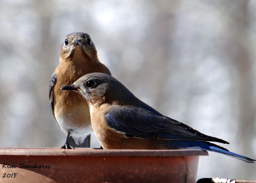

In [23]:
im = Image.open(dest)
im.to_thumb(256, 256)

In [6]:
searches = "forest", "bird"
path = Path("bird_or_not")

if not path.exists():
    path.mkdir()

if path.exists():
    for o in searches:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        #os.mkdir(dest)
        results = search_images_ddg(f'{o} photo')
        download_images(dest, urls=results[:200])
        resize_images(dest, max_size=400, dest=dest)

In [7]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


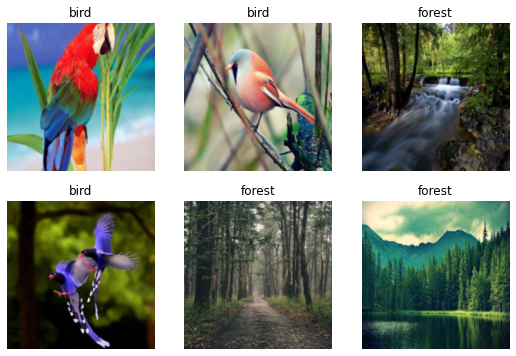

In [8]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42), 
    get_y=parent_label, 
    item_tfms=[Resize(192, method="squish")]
).dataloaders(path)

dls.show_batch(max_n=6)

In [9]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

C:\Users\schli\miniconda3\envs\fastai_lessons\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\schli\miniconda3\envs\fastai_lessons\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\schli/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.803723,0.481212,0.157895,00:29


epoch,train_loss,valid_loss,error_rate,time
0,0.056954,0.017037,0.000000,00:43
1,0.035353,0.000587,0.000000,00:42
2,0.025134,0.000197,0.000000,00:41


In [24]:
is_bird,_,probs=learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 1.0000


In [25]:
from fastcore.all import *
import time

def search_images(term, max_images=200):
    url = 'https://duckduckgo.com/'
    res = urlread(url,data={'q':term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
    urls,data = set(),{'next':1}
    while len(urls)<max_images and 'next' in data:
        data = urljson(requestUrl,data=params)
        urls.update(L(data['results']).itemgot('image'))
        requestUrl = url + data['next']
        time.sleep(0.2)
    return L(urls)[:max_images]

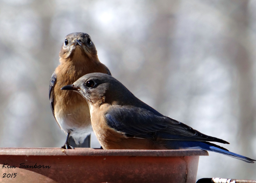

In [26]:
from fastdownload import download_url
dest = "birg.jpg"
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

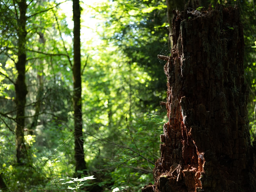

In [27]:
download_url(search_images('forest_photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open("forest.jpg").to_thumb(256,256)

In [ ]:
# searches = "forest","bird"
# path=Path("bird_or_not")

# for o in searches:
#     dest = (path/o)
#     dest.mkdir(exist_ok=True, parents=True)
#     download_images(dest, urls=search_images(f"{o} photo"))
#     resize_images(path/o, max_size=400, dest=path/o)

Segmentation model

In [ ]:
path = untar_data(URLs.CAMVID_TINY)
dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames = get_image_files(path/"images"),
    label_func = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
    codes = np.loadtxt(path/'codes.txt', dtype=str))

learn = unet_learner(dls, resnet34)
learn.fine_tune(8)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


C:\Users\schli\miniconda3\envs\fastai_lessons\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\schli/.cache\torch\hub\checkpoints\resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,time
0,2.700958,2.387323,01:03


epoch,train_loss,valid_loss,time
0,1.672135,1.321190,00:59
1,1.472282,1.275058,01:01
2,1.365701,1.027315,01:01
3,1.219191,0.829504,01:03
4,1.090750,0.753539,01:00
5,0.987948,0.725759,01:00
